In [47]:
import skimage.io as io
import numpy as np
import csv
import datetime
import glob
import ipywidgets as widgets
from PIL import Image as im
import os
from matplotlib import pyplot as plt
import skimage.morphology as skmorph
import scipy.ndimage as ndi
from skimage import data
from skimage import filters
from skimage import feature
import skimage.measure as skmeas
import skimage.segmentation as skseg
from skimage.feature import peak_local_max
import random
import pandas as pd
import cv2


# global variables
if os.name == "nt":
    FILE_SEP = "\\"
else:
    FILE_SEP = "/"

In [48]:
#Selecting Image Stack Files *From John's Notebook*
%matplotlib widget

# global variables
image_file = ""   # image stack name(s)
image_fps = 10


# create image file(s) widget
image_file = sorted([f.split(FILE_SEP)[-1] for f in glob.glob("../image_stacks/*", recursive=False)], key=str.casefold)
file_widget = widgets.Select(options=image_file, description='Image File', 
                            disabled=False, layout={'width':'500px'}, style={'description_width':'150px'})

# display and respond to the widgets
def f(w1):
  global image_file
  image_file = file_widget.value
display(widgets.interactive(f, w1=file_widget))

interactive(children=(Select(description='Image File', layout=Layout(width='500px'), options=('hR1 exo 69 CCh …

In [49]:
#Selecting Image Stack Files *From John's Notebook*
%matplotlib widget

# global variables
image_stacks = {}    # image stack name(s)
image_fps = 10

file_location = "../image_stacks/" + image_file + "/*.tif"

# create image file(s) widget
image_stacks = sorted([f.split(FILE_SEP)[-1] for f in glob.glob(file_location, recursive=False)], key=str.casefold)
image_widget = widgets.SelectMultiple(options=image_stacks, description='Image stack(s)', 
                            disabled=False, layout={'width':'400px'}, style={'description_width':'150px'})

# display and respond to the widgets
def f(w1):
  global image_stacks
  image_stacks = image_widget.value
display(widgets.interactive(f, w1=image_widget))

interactive(children=(SelectMultiple(description='Image stack(s)', layout=Layout(width='400px'), options=('hR1…

In [50]:
### Image stack labels *From John's Notebook*
%matplotlib widget

# global variables
image_tags = []         # list of image file tag labels
roi_idx = 0             # image file index to use to use for generating roi's

# create image tag widget(s)
image_tag_widgets = []
m = 6                   # a static number of widgets to display
n = len(image_stacks)    # the number of image stack files selected
for i in range(m):
  if i >= n:
    d = ' '
  else:
    d = image_stacks[i]
  image_tag_widgets.append(widgets.Text(value='', placeholder='enter a label', description=d,
                    disabled=(i>=n), layout={'width':'800px'}, style={'description_width':'400px'}))
# display and respond to the widgets
def f(w1,w2,w3,w4,w5,w6):
  global image_tags, roi_idx
  image_tags = [(w.value,idx) for idx,w in enumerate(image_tag_widgets)]
  for t in image_tags[:n]:
    print('Is label "' + t[0] + '" alpha-numeric?', t[0].isalnum())
display(widgets.interactive(f, w1=image_tag_widgets[0],
                               w2=image_tag_widgets[1],
                               w3=image_tag_widgets[2],
                               w4=image_tag_widgets[3],
                               w5=image_tag_widgets[4],
                               w6=image_tag_widgets[5]))


interactive(children=(Text(value='', description='hR1 exo 69 CCH 3 10 and 30 uM CCH_2 340nm.tif', layout=Layou…

In [51]:
#Obtaining roi_idx value from user *Excerpt From John's Notebook*
%matplotlib widget

# global variables
roi_idx = 0
meas_idx = 0

s = {'description_width':'200px'} # a default widget style

# create roi tag widget
roi_tag_widget = widgets.Dropdown(options=image_tags[0:len(image_stacks)], 
                 value=roi_idx, description='Image stack for ROI creation', 
                 disabled=False, layout={'width':'600px'}, style=s)
# create measurement tag widget
meas_tag_widget = widgets.Dropdown(options=image_tags[0:len(image_stacks)],
                  value=meas_idx, description='Image stack for measurement',
                  disabled=False, layout={'width':'600px'}, style=s)

# display and respond to widget
def f(w1,w2):
    global roi_idx, meas_idx
    meas_idx = meas_tag_widget.value
    roi_idx = roi_tag_widget.value
display(widgets.interactive(f, w1=roi_tag_widget, w2=meas_tag_widget))

interactive(children=(Dropdown(description='Image stack for ROI creation', layout=Layout(width='600px'), optio…

In [52]:
#Timestamped results directory *From John's Notebook*
# create time-stamped results directory
if not os.path.exists("../results"):
  os.mkdir("../results")
resultsdir = str(datetime.datetime.now())[:-7]
resultsdir = resultsdir.replace('-', '').replace(' ', '-').replace(':','')
resultsdir = "../results/" + resultsdir
os.mkdir(resultsdir)

# write out the image stack file names used
f = open(resultsdir + '/' + "image_stacks.txt", "w")
for v in image_stacks:
  f.write(v+'\n')
f.close()

# write out the labels used
f = open(resultsdir + '/' + "labels.txt", "w")
for i in range(len(image_stacks)):
  f.write(image_tags[i][0]+'\n')
f.close()

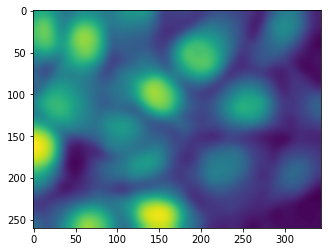

In [53]:
%matplotlib inline
#Reading in image
A0_Original = io.imread("../image_stacks/" + image_file + "/" + image_stacks[roi_idx], plugin="tifffile")
B0_Original = io.imread("../image_stacks/" + image_file + "/" + image_stacks[meas_idx], plugin="tifffile")

for i in range(2,A0_Original.shape[0]-2):         # calculate moving average for ROI image
    A0_Original[i] = np.mean(A0_Original[i-2:i+2+1], axis=0)
for i in range(2):                       # duplicate beginning and ending frames for ROI image
    A0_Original[i] = A0_Original[2]
    A0_Original[-(1+i)] = A0_Original[-(2+1)]  
    
for i in range(2,B0_Original.shape[0]-2):         # calculate moving average for measurement image
    B0_Original[i] = np.mean(B0_Original[i-2:i+2+1], axis=0)
for i in range(2):                       # duplicate beginning and ending frames for measurement image
    B0_Original[i] = B0_Original[2]
    B0_Original[-(1+i)] = B0_Original[-(2+1)]

#Smoothing Tifs
A0_Smoothed = []
B0_Smoothed = []

for i in A0_Original:
    smoothed = ndi.gaussian_filter(i, sigma=5)
    A0_Smoothed.append(smoothed)
for i in B0_Original:
    smoothed = ndi.gaussian_filter(i, sigma=5)
    B0_Smoothed.append(smoothed)
    
A0 = np.stack(A0_Smoothed) 
B0 = np.stack(B0_Smoothed)

# Finding frame with most pixel intensity
def get_max_frame(A0):
    A0_max = np.where(A0 == np.max(A0))
    img = A0[A0_max[0]]
    img = img[0,:,:]
    return img

baseline_img = get_max_frame(A0)

# Ratio image is first frame of ratio tif
ratio_img = B0[0]
# Setting any uint16 image value over 255 to 255, prevents integer overflow
baseline_img[baseline_img > 255] = 255
img = baseline_img.astype('uint8')
plt.imshow(img)

In [54]:
# Threshold framesize widget
%matplotlib widget
threshold_size = 0

threshold_widget = widgets.Dropdown(
    options=[('small',41),('medium',71),('large',141)],
    value=41,
    description='Threshold Frame Size:',
    disabled=False,
    layout={'width':'350px'}, style={'description_width':'180px'}
)

# display and respond to the widget
def f(w1):
    global threshold_size
    threshold_size = threshold_widget.value
display(widgets.interactive(f, w1=threshold_widget))



interactive(children=(Dropdown(description='Threshold Frame Size:', layout=Layout(width='350px'), options=(('s…

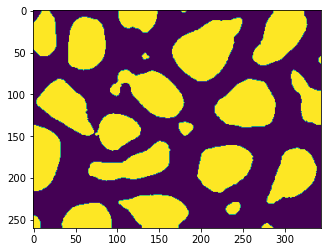

In [55]:
# Thresholding
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,threshold_size,-1)

#Denoising mask, improves watershed transform output
%matplotlib inline
mask = filters.median(th2)
mask = skmorph.binary_dilation(mask)
mask = ndi.binary_fill_holes(mask)
plt.imshow(mask)

In [56]:
%matplotlib widget
#Global erosion variable
erosions = 0
max_size = 2000
min_size = 50
keep_edge_ROIS = True
#Creating erosions widget
erosions_widget = widgets.BoundedIntText(value=erosions, min=0, max=10, step=1,
                    description='Number of erosions', disabled=False, layout={'width':'270px'}, style=s)
max_size_widget = widgets.BoundedIntText(value=max_size, min=500, max=8000, step=50,
                    description='Max Size of ROIs', disabled=False, layout={'width':'270px'}, style=s)
min_size_widget = widgets.BoundedIntText(value=min_size, min=0, max=8000, step=50,
                    description='Min Size of ROIs', disabled=False, layout={'width':'270px'}, style=s)
keep_edge_ROIS_widget = widgets.Checkbox(value=keep_edge_ROIS, layout={'width':'300px'}, style = s, 
                                         description="Un-Check this box to discard edge ROIS",
                                         disabled=False, indent=False)
def f(w1,w2,w3,w4):
    global erosions, max_size, min_size, keep_edge_ROIS
    erosions = erosions_widget.value
    max_size = max_size_widget.value
    min_size = min_size_widget.value
    keep_edge_ROIS = keep_edge_ROIS_widget.value
display(widgets.interactive(f,w1=max_size_widget,w2=min_size_widget,w3=erosions_widget, w4=keep_edge_ROIS_widget))

interactive(children=(BoundedIntText(value=2000, description='Max Size of ROIs', layout=Layout(width='270px'),…

In [75]:
%matplotlib inline
#Performing Erosions
for i in range(erosions):
    mask = skmorph.binary_erosion(mask)
#Labeling Objects
object_labels = skmeas.label(mask)

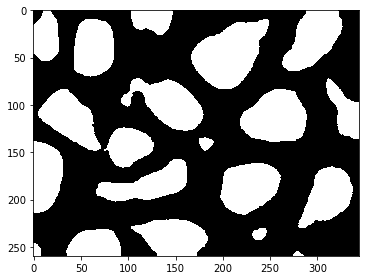

In [76]:
%matplotlib inline
# For max size of ~3000-4000, good values are 7.0 for h, 12 for min distance, and 12 for footprint
#h_size = 
#min_dist_val =

#Applying watershed transform to split touch objects
dist = ndi.distance_transform_edt(mask)
#Filtering distance transform
h = 4.0
h_maxima = skmorph.extrema.h_maxima(dist,h)
coords = peak_local_max(h_maxima,min_distance = 10, exclude_border=False, footprint=np.ones((12,12)),labels=mask)
watershed_mask = np.zeros(dist.shape, dtype=bool)
watershed_mask[tuple(coords.T)] = True
markers, _ = ndi.label(watershed_mask)
labels = skseg.watershed(-dist,markers,mask=mask,watershed_line=True)

#Dilating watershed lines to help with separation
watershed_lines = np.zeros(shape=np.shape(labels))
watershed_lines[labels==0]=1
labels = skmorph.binary_dilation(watershed_lines)
labels = skmorph.binary_dilation(watershed_lines)
labels = ~labels


io.imshow(labels)

In [77]:
%matplotlib inline
#Closing edges
eroded_water = skmorph.binary_erosion(labels)
eroded_water_2 = skmorph.binary_erosion(eroded_water)
closed_one = skmorph.binary_closing(eroded_water_2)
closed_two = skmorph.binary_closing(closed_one)

In [78]:
%matplotlib inline
#Canny edge detection
edges = feature.canny(closed_two, sigma = 3).astype(int)
dilated_edges = skmorph.binary_dilation(edges).astype(int)
#Edge ROI sealing if keep ROIS is 
if keep_edge_ROIS == True:
    count = 0
    while count < max_size:
        rand_x = random.randint(0,edges.shape[0])
        rand_y = random.randint(0,edges.shape[0])
        final = skseg.flood_fill(dilated_edges,(rand_x,rand_y), 5)
        count = np.count_nonzero(final == 5)
    final[final<2] = 255
else:
    final = ndi.binary_fill_holes(dilated_edges)

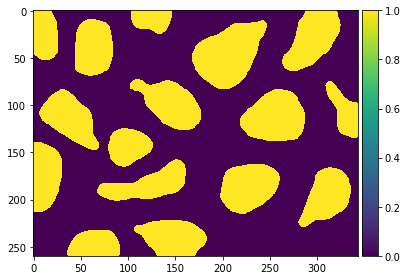

In [79]:
mask_label = skmeas.label(final)
objs = skmeas.regionprops(mask_label)
final = np.zeros_like(mask_label)

#Removing large objects and objects with very low average intensity in ratio image
for obj in objs:
    ratio_mean = 0
    for x_coord, y_coord in obj.coords:
        ratio_mean += ratio_img[x_coord,y_coord]
    ratio_mean = ratio_mean / len(obj.coords)
    if ratio_mean > 1 and obj.area < max_size and obj.area > min_size:
        final = final + (mask_label == obj.label)
io.imshow(final)

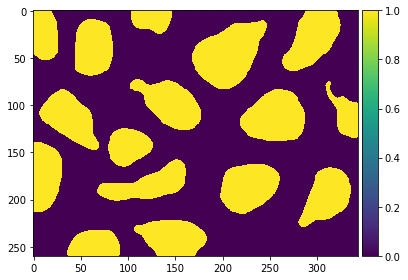

In [80]:
# Thresholding
final = final.astype(np.uint8)
ret, ratio_mask = cv2.threshold(ratio_img, 1, 255, cv2.THRESH_BINARY)
ratio_mask = ratio_mask.astype(np.uint8)
#BitwiseAND operation to only keep parts of ROIs that are present in both original mask and ratio_img mask
real_mask = cv2.bitwise_and(ratio_mask,final)
#Setting final to be real mask
final = real_mask
mask_label = skmeas.label(final)
objs = skmeas.regionprops(mask_label)
final = np.zeros_like(mask_label)

#Final removal of any accidental ROIs created
for obj in objs:
    if obj.area < max_size and obj.area > min_size:
        final = final + (mask_label == obj.label)
io.imshow(final)

In [81]:
# For removal of unwanted ROIs
%matplotlib widget
R, n = skmeas.label(final, return_num = True)
ROI, COUNT = np.unique(R, return_counts= True)
# create regions for removal widget
removal_widget = widgets.SelectMultiple(options=ROI[1:], description='ROIs for Removal',
                            disabled=False, layout={'width':'175px', 'height':'120px'}, style={'description_width':'100px'})
def f(w1):
  global rois_removed
  rois_removed = removal_widget.value
display(widgets.interactive(f, w1=removal_widget))

interactive(children=(SelectMultiple(description='ROIs for Removal', layout=Layout(height='120px', width='175p…

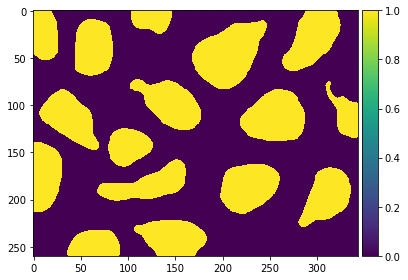

In [82]:
# For removal of unwanted ROIS 
%matplotlib inline
for c in rois_removed:
    final[R==ROI[c]] = 0
io.imshow(final)

In [83]:
#Label and ID ROIS *From John's Notebook*
R, n = skmeas.label(final, return_num=True)
ROI, COUNT = np.unique(R, return_counts=True)

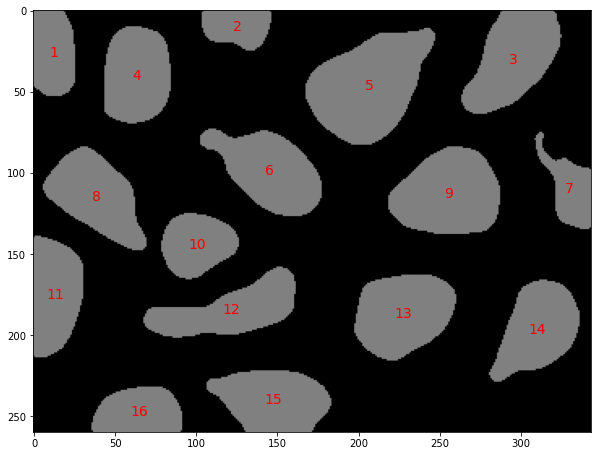

apical ROI labels:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
apical ROI pixel counts:  [1266  862 2517 2100 3674 2458  980 2286 2851 1424 1900 2139 2521 2187
 2225 1326]


In [84]:
%matplotlib inline
#Plot labels of ROIS on image *From John's Notebook*
io.imsave(resultsdir + "/" + image_tags[roi_idx][0] + "-roi_mask_labelled.tif", np.int16(R), check_contrast=False) # Save labeled ROI Mask for movie
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 10])
ax.imshow(final, norm=None, vmax=2, cmap='gray') # dim the white a bit, easier to see the annnotations
for props in skmeas.regionprops(R):
  y, x = props.centroid # get the centroid for each region
  t = ax.text(x, y, str(props.label), ha='center', va='center', size=14, c='r')
plt.show()
print("apical ROI labels: ", ROI[1:])
print("apical ROI pixel counts: ", COUNT[1:])

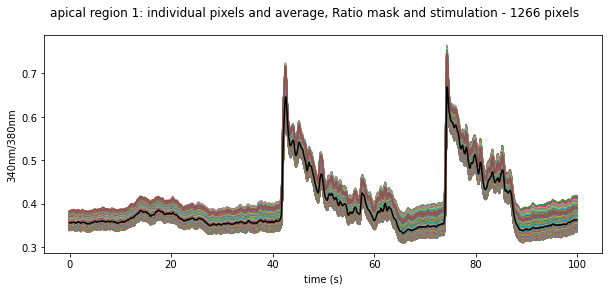

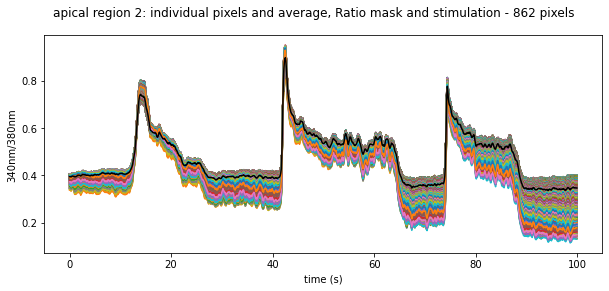

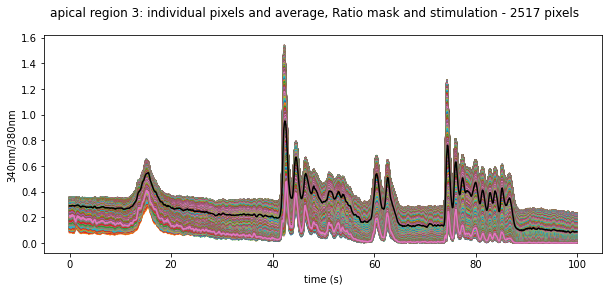

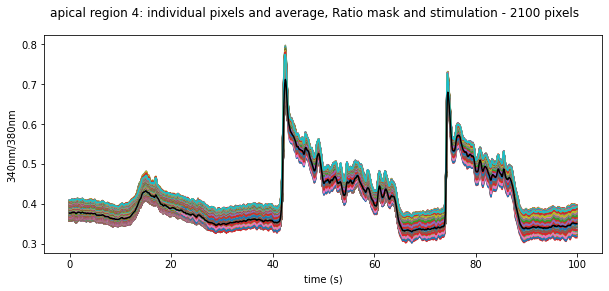

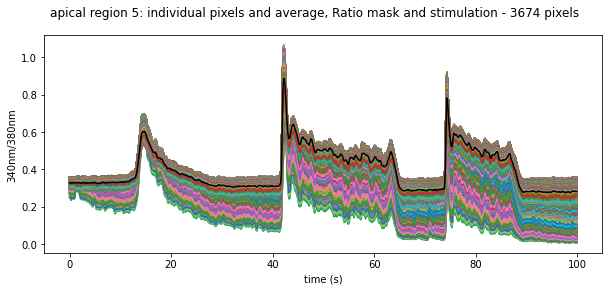

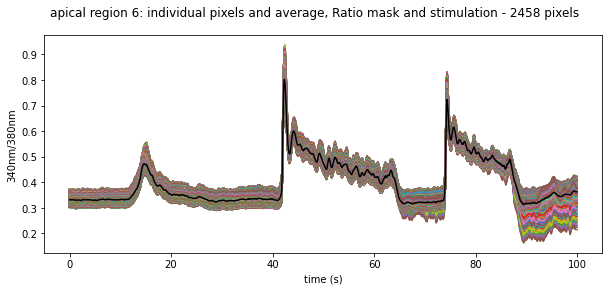

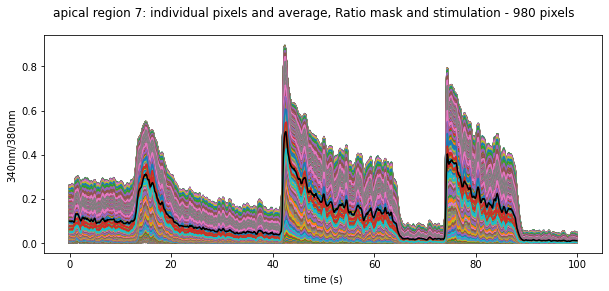

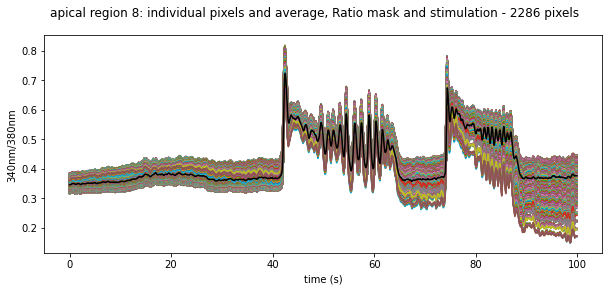

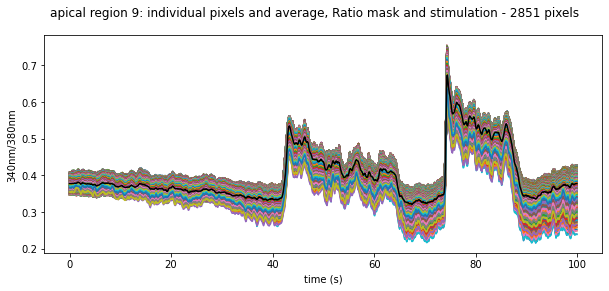

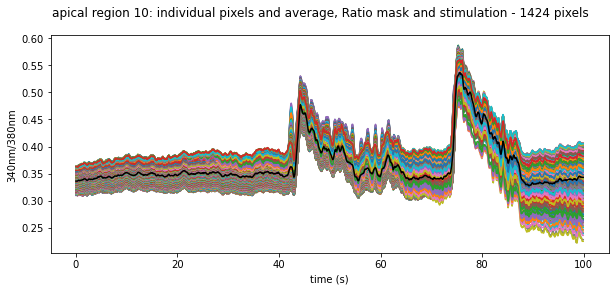

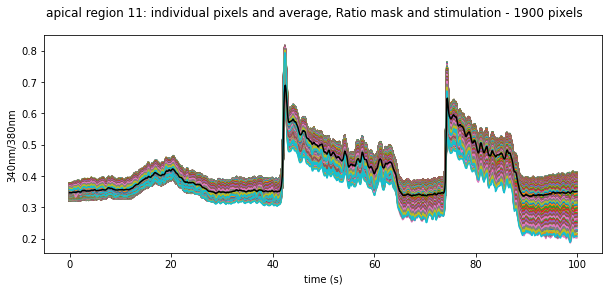

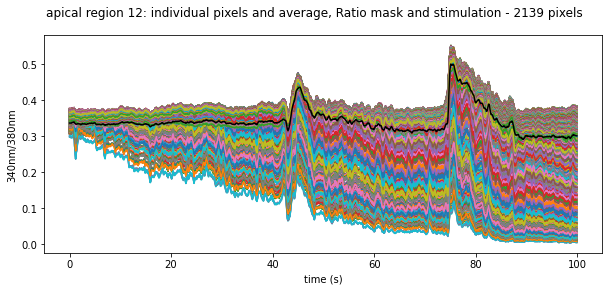

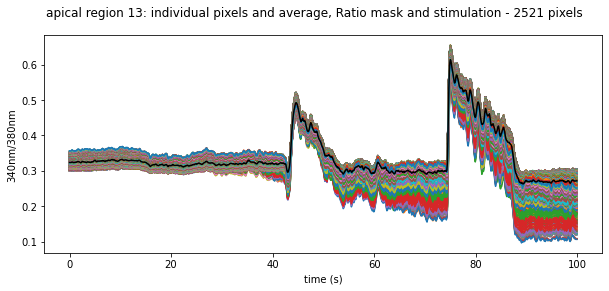

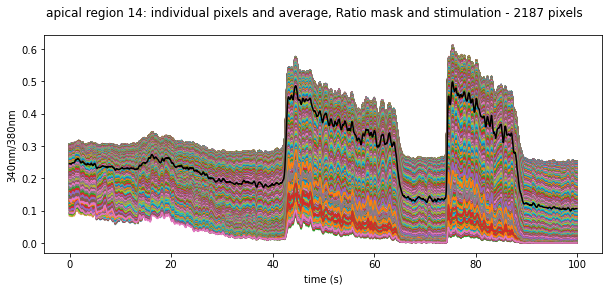

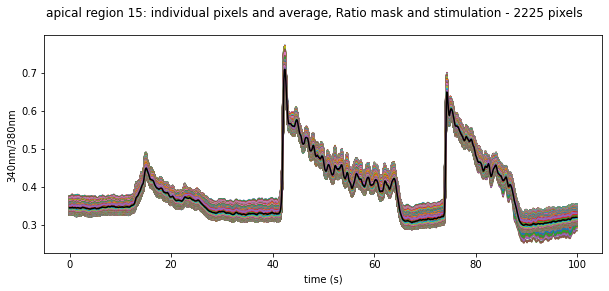

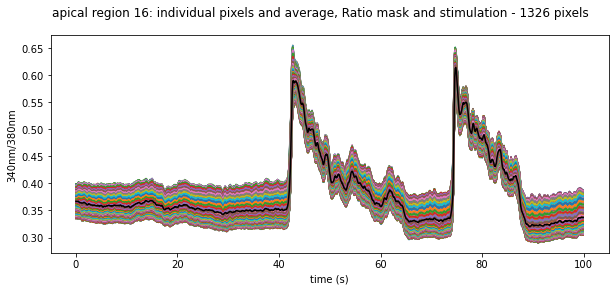

In [85]:
#Plotting region responses *From John's Notebook*
%matplotlib inline

# apical region plots using the mask
X = np.array(range(B0.shape[0])) * (1/image_fps) # the timebase

# create and save plots
for c in ROI:
  if(c==0):
    continue
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
  fig.suptitle('apical region ' + str(c)+ ": individual pixels and average, " + image_tags[meas_idx][0] + " mask and stimulation - " +str(COUNT[c]) + " pixels")
  S = B0[:, R==ROI[c]] / 1000
  T = np.sum(S, axis=1) / S.shape[1]
  ax.plot(X, S)
  ax.plot(X, T, color='black')
  ax.set(ylabel="340nm/380nm")
  ax.set(xlabel="time (s)")

  # save figure to pdf
  s = "/apical_region_" + str(c).zfill(2) + "-mask" + image_tags[meas_idx][0] + "-stim" + image_tags[meas_idx][0] + ".pdf"
  fig.savefig(resultsdir + s)
  
  plt.show()
  plt.close() # frees up memory


In [86]:
#Widget for choice of all image stacks or just ratio
%matplotlib widget
#Global Variables
just_ratio = True
s = {'description_width':'200px'} # a default widget style

#Create just_ratio widget
just_ratio_widget = widgets.Checkbox(value=True, 
                                     description="Uncheck this box to display 340nm and 380nm",
                                     disabled=False,
                                     indent=False)
def f(w1):
    global just_ratio
    just_ratio = just_ratio_widget.value
display(widgets.interactive(f,w1=just_ratio_widget))
    


interactive(children=(Checkbox(value=True, description='Uncheck this box to display 340nm and 380nm', indent=F…

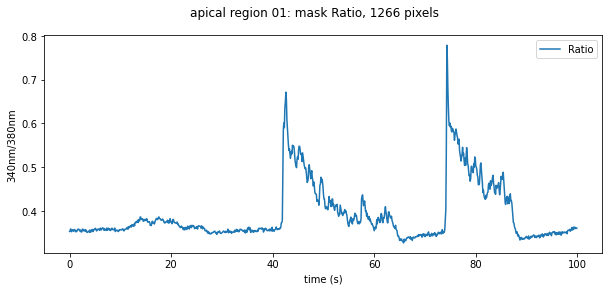

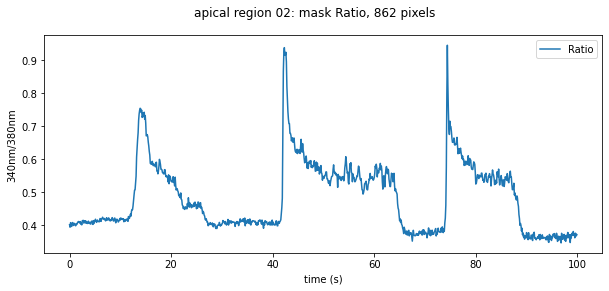

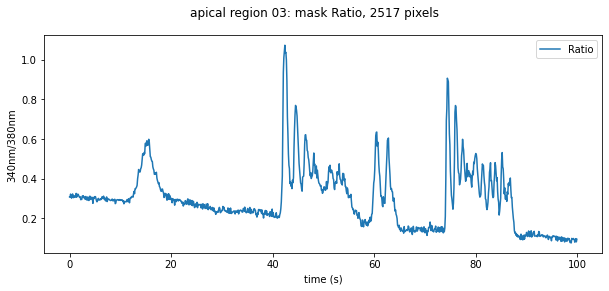

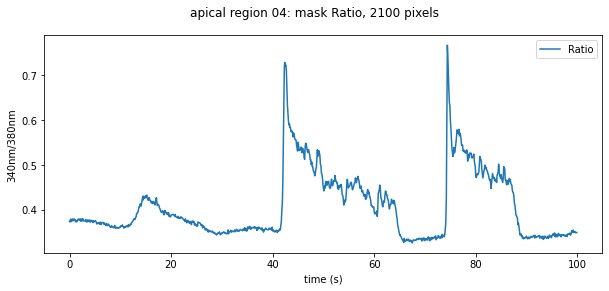

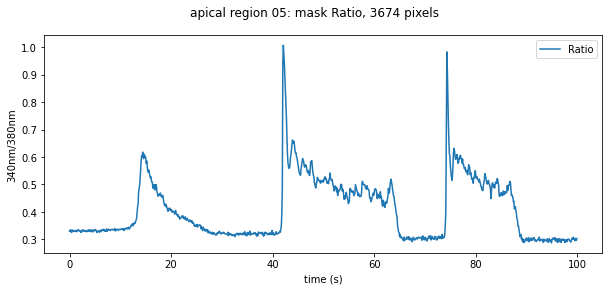

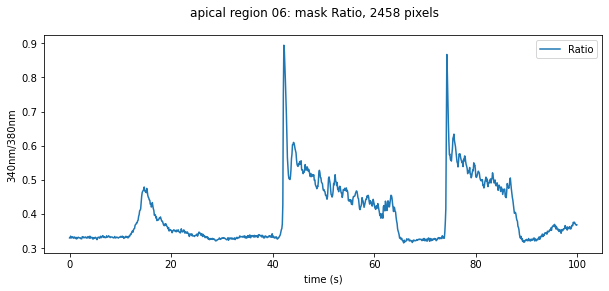

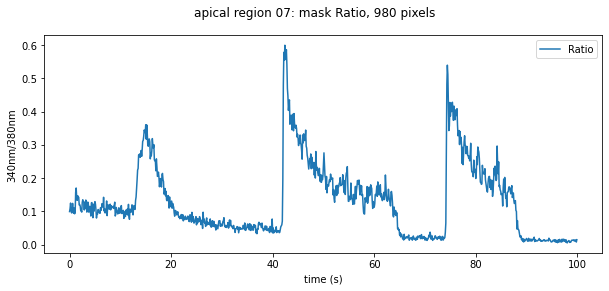

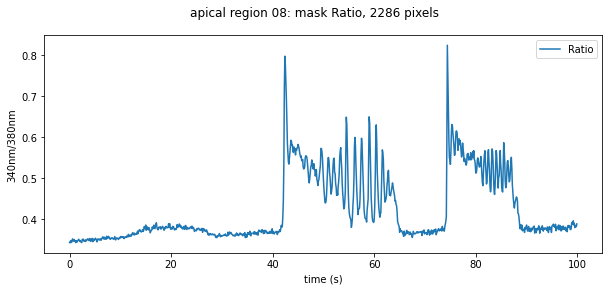

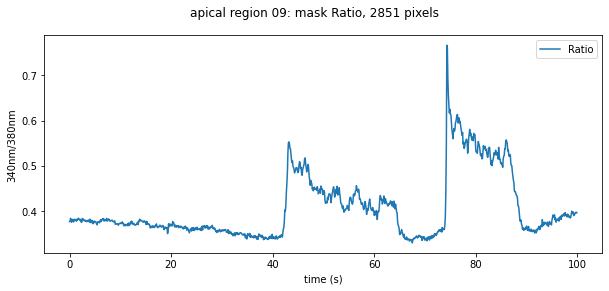

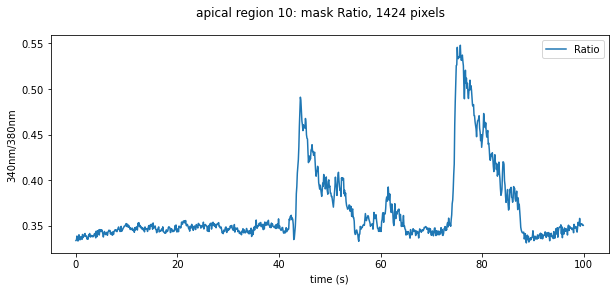

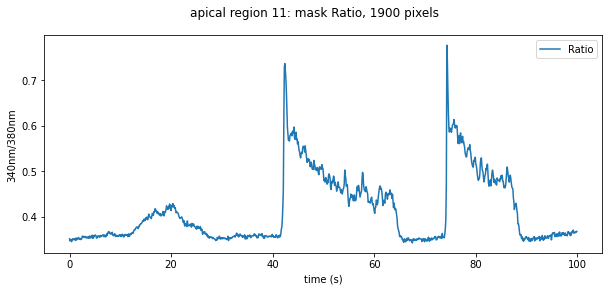

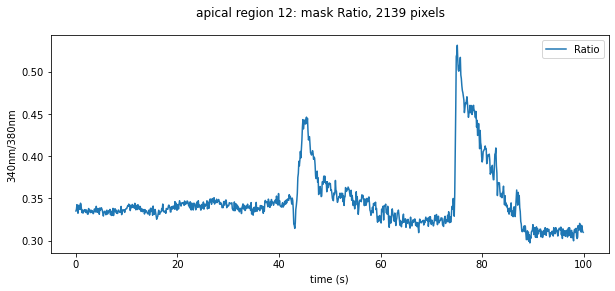

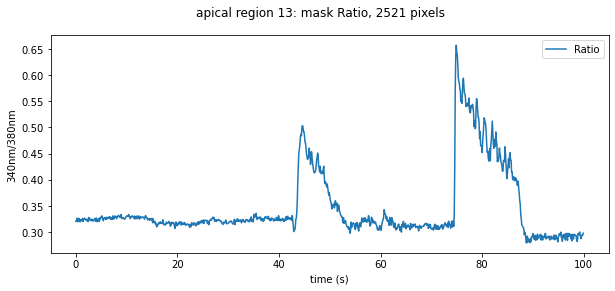

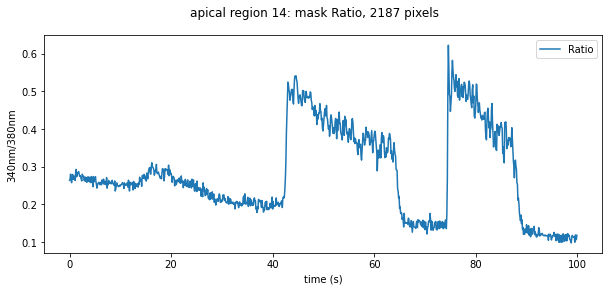

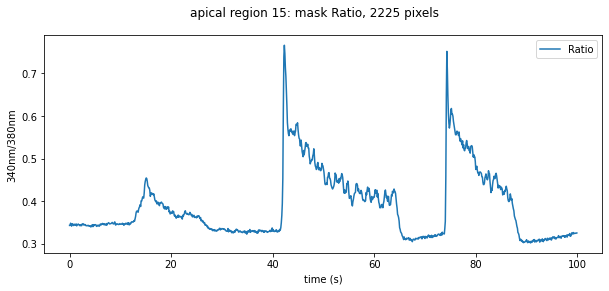

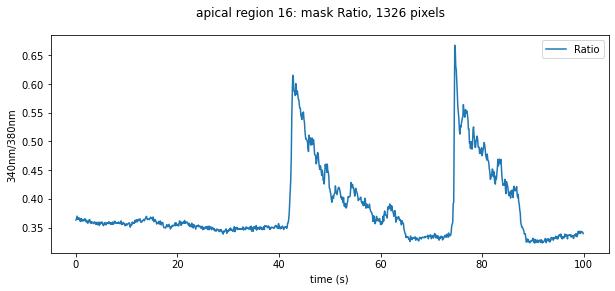

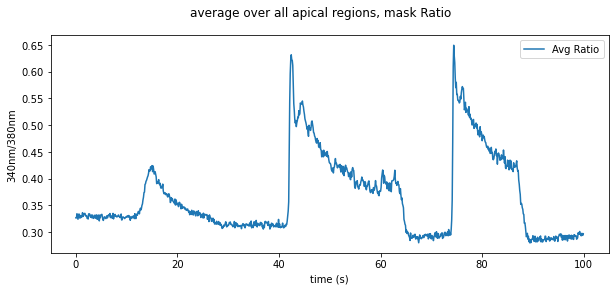

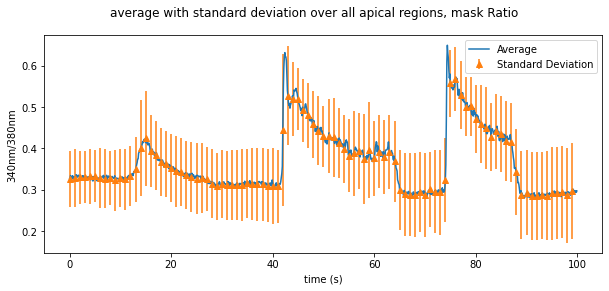

In [87]:
#Saving average graphs *From John's Notebook*
%matplotlib inline

# calculate, plot and save region responses for all stimulation frequencies

# calculate all of the results
if just_ratio == False:
    RESULTS = np.zeros((len(image_stacks), ROI.shape[0]-1, B0.shape[0])) # array for all of the apical results
else:
    RESULTS = np.zeros((1, ROI.shape[0]-1, B0.shape[0])) # array for all of the apical results
X = np.array(range(RESULTS.shape[2])) * (1/image_fps) # the timebase

# get image stack
if just_ratio == False:
    for f in image_stacks:
        A0x = io.imread("../image_stacks/" + image_file + "/" + f)
        for c in ROI:
          if(c==0):
             continue 
          S = A0x[:, R==ROI[c]] / 1000
          T = np.sum(S, axis=1) / S.shape[1]
          RESULTS[list(image_stacks).index(f), c-1] = T # save in the results array
else:
    f = image_stacks[meas_idx]
    A0x = io.imread("../image_stacks/" + image_file + "/" + f)
    for c in ROI:
     if(c==0):
        continue 
     S = A0x[:, R==ROI[c]] / 1000
     T = np.sum(S, axis=1) / S.shape[1]
     RESULTS[0, c-1] = T # save in the results array

# plot and save responses for all the stimulation frequencies by region
for n in range(1,len(ROI)):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
  fig.suptitle('apical region ' + str(ROI[n]).zfill(2) + ": mask "+ image_tags[meas_idx][0] + ", " + str(COUNT[n]) + " pixels")
  if just_ratio == False:
      ax.plot(X, np.transpose(RESULTS[:, n-1, :]))
  else:
      ax.plot(X, np.transpose(RESULTS[0, n-1, :]), label="Ratio")
  if just_ratio == False:
      ax.set(ylabel="%F/F0")
  else:
      ax.set(ylabel="340nm/380nm")
  ax.set(xlabel="time (s)")
  if just_ratio == False:
      ax.legend([t[0] for t in image_tags][0:len(image_stacks)])
  else:
      ax.legend(loc='best')

  # save figure to pdf
  if just_ratio == False:
      continue
  else:
      fig.savefig(resultsdir + "/apical_region_" + str(n).zfill(2) + "-mask" + 
                  image_tags[meas_idx][0] + "-stimALL.pdf")
    
  plt.show()
  plt.close() # frees up memory
  
  # save responses to CSV file
  with open (resultsdir + "/apical_region_" + str(n).zfill(2) + 
             "-mask" + image_tags[meas_idx][0] + "-stimALL.csv", 'w', newline="") as file:
    writer = csv.writer(file)
    for i in range(RESULTS.shape[2]):
      t = np.append(X[i], RESULTS[:,n-1,i])
      writer.writerow('{:3.3e}'.format(x) for x in t)
if just_ratio == True:
    # plot average of region responses for all the stimulation frequencies
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
    fig.suptitle("average over all apical regions, mask "+ image_tags[meas_idx][0])

    Y = np.transpose(np.sum(RESULTS, axis=(1)))/RESULTS.shape[1]

    ax.plot(X, Y, label="Avg Ratio")
    ax.set(ylabel="340nm/380nm")
    ax.set(xlabel="time (s)")
    ax.legend(loc='best')

    # save figure to pdf
    fig.savefig(resultsdir + "/apical_region_AVG-mask" + image_tags[meas_idx][0] + "-stimALL.pdf")
    
    plt.show()
    plt.close() # frees up memory

    # save average of responses to CSV file
    with open (resultsdir + "/apical_region_AVG-mask" + image_tags[meas_idx][0] + "-stimALL.csv", 'w', newline="") as file:
      writer = csv.writer(file)
      for i in range(X.shape[0]):
        t = np.append(X[i], Y[i])
        writer.writerow('{:3.3e}'.format(x) for x in t)
    
    # creating separate averages results file
    if not os.path.exists("../results_avgs"):
      os.mkdir("../results_avgs")
    avgs_dir = "../results_avgs/"

    # save average of responses to separate results file
    with open (avgs_dir + "/results_avg_for" + image_tags[meas_idx][0] + ".csv", 'w', newline="") as file:
        writer = csv.writer(file)
        for i in range(X.shape[0]):
            t = np.append(X[i], Y[i])
            writer.writerow('{:3.3e}'.format(x) for x in t)
    

    # save total responses to single CSV file
    total_list = []    
    temp_list = []
    for x in X: #Adding time step column
        temp_list.append(x)
    total_list.append(temp_list[:])
    temp_list.clear()
    for c in ROI:
        f = image_stacks[meas_idx]
        A0x = io.imread("../image_stacks/" + image_file + "/" + f)
        if(c==0):
            continue
        S = A0x[:,R==ROI[c]] / 1000
        T = np.sum(S, axis=1) / S.shape[1]
        for t in T:
            temp_list.append(t)
        total_list.append(temp_list[:]) #Append copy of temp list to total list
        temp_list.clear()
    
    std_df = pd.DataFrame(total_list) #Creating dataframe without average col, for std plotting

    #Total responses single CSV file cont'd
    for y in Y:
        temp_list.append(y[0])
    total_list.append(temp_list[:])
    df = pd.DataFrame(total_list).T  #Creating and transposing data frame so each region is its own column
    df.to_csv("../image_stacks/" + image_tags[meas_idx][0] + "-stimALL.csv",
              index=False,header=False ) #Converting dataframe to csv file    

    #Standard deviation calculations and graphing
    std_df = std_df[1:] # removing time step row from dataframe
    std = std_df.std(axis=0,skipna=True)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
    fig.suptitle("average with standard deviation over all apical regions, mask "+ image_tags[meas_idx][0])
    avg = []
    for y in Y:
        avg.append(y) #Creating list of averages of measurement data
    ax.plot(X, avg, label="Average") #Plotting average of measurement data
    ax.errorbar(X[0::10],avg[0::10],std[0::10], linestyle='None', 
                marker='^', label="Standard Deviation") # std plotting of every 10th point's std
    ax.set(ylabel="340nm/380nm")
    ax.set(xlabel="time (s)")
    ax.legend(loc = 'best')
    plt.show()
    plt.close()